# King County Project

## Business Problem

A client in King County, WA wants to advise homeowners on **home improvement projects** that will **add to the sale value of their homes**.

**This advice should be based on data from the most recent full calendar year, 2019**.

### Sample Questions:
Enclosing a porch will increase the sale price of a home.

Converting a garage to a bedroom is a good way to increase the sale price of a home.

Upgrading to a forced-air heating system will increase the sale price of a home.

### Core Goals:
Create model

Interpret results

Make recomendations

# Initial EDA Work

### Importing Libraries and Adjusting Settings

In [1]:
# import modules for eda and plotting
import pandas as pd
import numpy as np
import scipy.stats as stats

import sqlite3

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

import functions as fn

# setting plots to inline
%matplotlib inline

# setting the max number of rows displayed
pd.options.display.max_rows = 300

## SQL Dataframe

### SQL Prelim Work

#### Created Database
Earlier, wrote up a [DB Creator](DB_Creator.ipynb) notebook and ran it to create an SQL database from the raw `.csv` files.

#### Creating DataFrame From the Database

Connecting to the database, and creating a cursor object. Joining the database tables into a second main data frame. Lastly, checking basic information about the data frame.

In [2]:
# creating database, connection, and cursor
conn = sqlite3.connect('KingDB.db')  
cur = conn.cursor()

In [3]:
# checking the table names
q = """SELECT name FROM sqlite_master 
WHERE type IN ('table','view') 
AND name NOT LIKE 'sqlite_%'
ORDER BY 1"""
fn.fetch(cur, q)

[('LOOK',), ('PARC',), ('RESB',), ('SALES',)]

### Joining Tables to Create the Main Data Frame

In [4]:
# joining tables to create dataframe and appending column names
q = """SELECT*FROM SALES AS SA
       JOIN PARC AS PA
       ON SA.Major = PA.Major
       AND SA.Minor = PA.Minor
       JOIN RESB AS RE
       ON PA.Major = RE.Major
       AND PA.Minor = RE.Minor
       """
df = pd.DataFrame(fn.fetch(cur, q))
df.columns = [i[0] for i in cur.description]

In [5]:
# checking info, shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251300 entries, 0 to 251299
Columns: 156 entries, ExciseTaxNbr to AddnlCost
dtypes: object(156)
memory usage: 299.1+ MB


In [6]:
df.shape

(251300, 156)

### Creating the Lookup Data Frame

In [7]:
# joining tables to create dataframe and appending column names
q = """SELECT*FROM LOOK"""
look = pd.DataFrame(fn.fetch(cur, q))
look.columns = [i[0] for i in cur.description]

#### Checking the Lookup Data Frame

Getting basic info, checking the first row, description strings, and cleaning the columns.

In [8]:
# getting info for lookup data frame
look.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LUType         1208 non-null   object
 1   LUItem         1208 non-null   object
 2   LUDescription  1208 non-null   object
dtypes: object(3)
memory usage: 28.4+ KB


In [9]:
# checking first row
look.head(1)

,LUType,LUItem,LUDescription
0,1,1,LAND ONLY ...


In [10]:
# checking strings
look.LUType.values[:2], look.LUItem.values[:2], look.LUDescription.values[:2]

(array(['1  ', '1  '], dtype=object),
 array(['1  ', '10 '], dtype=object),
 array(['LAND ONLY                                         ',
        'Land with new building                            '], dtype=object))

Cleaning strings and checking results.

In [11]:
# cleaning strings
look['LUType'] = fn.col_stripper(look, 'LUType')
look['LUItem'] = fn.col_stripper(look, 'LUItem')
look['LUDescription'] = fn.col_stripper(look, 'LUDescription')

In [12]:
# checking results
print(look.LUType.values)
print(look.LUItem.values)
look.LUDescription.values

['1' '1' '1' ... '99' '99' '99']
['1' '10' '11' ... '3' '4' '5']


array(['LAND ONLY', 'Land with new building',
       'Household, single family units', ..., 'AVERAGE', 'ABOVE AVERAGE',
       'EXCELLENT'], dtype=object)

### Checking & Dealing with Columns in Main Data Frame
Working through the columns of the main data frame to narrow down the list of features to a more manageable size.

In [13]:
# checking columns
list(df.columns)

['ExciseTaxNbr',
 'Major',
 'Minor',
 'DocumentDate',
 'SalePrice',
 'RecordingNbr',
 'Volume',
 'Page',
 'PlatNbr',
 'PlatType',
 'PlatLot',
 'PlatBlock',
 'SellerName',
 'BuyerName',
 'PropertyType',
 'PrincipalUse',
 'SaleInstrument',
 'AFForestLand',
 'AFCurrentUseLand',
 'AFNonProfitUse',
 'AFHistoricProperty',
 'SaleReason',
 'PropertyClass',
 'SaleWarning',
 'Unnamed: 0',
 'Major',
 'Minor',
 'PropName',
 'PlatName',
 'PlatLot',
 'PlatBlock',
 'Range',
 'Township',
 'Section',
 'QuarterSection',
 'PropType',
 'Area',
 'SubArea',
 'SpecArea',
 'SpecSubArea',
 'DistrictName',
 'LevyCode',
 'CurrentZoning',
 'HBUAsIfVacant',
 'HBUAsImproved',
 'PresentUse',
 'SqFtLot',
 'WaterSystem',
 'SewerSystem',
 'Access',
 'Topography',
 'StreetSurface',
 'RestrictiveSzShape',
 'InadequateParking',
 'PcntUnusable',
 'Unbuildable',
 'MtRainier',
 'Olympics',
 'Cascades',
 'Territorial',
 'SeattleSkyline',
 'PugetSound',
 'LakeWashington',
 'LakeSammamish',
 'SmallLakeRiverCreek',
 'OtherView',

#### Removing `Unnamed: 0` Column

In [14]:
# using custom dropper function to remove unnamed column found above
fn.dropper(df, ['Unnamed: 0'], True)

## Checking `PropertyType`, `PropertyClass`, `PropType`


In [15]:
df[['PropertyType', 'PropertyClass', 'PropType']].head(3)

,PropertyType,PropertyClass,PropType
0,3,8,R
1,2,8,R
2,3,8,R


Checking Lookup Codes

In [16]:
fn.lookup(look, 1), fn.lookup(look,4)

(   LUType LUItem                                      LUDescription
 0       1      1                                          LAND ONLY
 1       1     10                             Land with new building
 2       1     11                     Household, single family units
 3       1     12  Multiple family residence (Residential, 2-4 un...
 4       1     13  Multiple family residence (Residential, 5+ units)
 5       1     14                           Residential condominiums
 6       1     15                        Mobile home parks or courts
 7       1     16                                      Hotels/motels
 8       1     17                              Institutional lodging
 9       1     18          All other residential not elsewhere coded
 10      1     19                                 Vacation and cabin
 11      1      2                             LAND WITH NEW BUILDING
 12      1     21                          Food and kindred products
 13      1     22                 

#### Making `PropType` Lookup Data Frame

In [17]:
# PropType Codes 
codes = ['C', 'K', 'M', 'N', 'R', 'T', 'U', 'X']
ptypes = ['Commercial', 'Condominium', 'Coal & Mineral Rights',\
            'Mining', 'Residential', 'Timber', 'Undivided Interest', 'Exempt']
pt = {'LUItem': codes, 'LUDescription': ptypes}
PropTypes = pd.DataFrame().from_dict(pt)
PropTypes

,LUItem,LUDescription
0,C,Commercial
1,K,Condominium
2,M,Coal & Mineral Rights
3,N,Mining
4,R,Residential
5,T,Timber
6,U,Undivided Interest
7,X,Exempt


In [18]:
df.groupby('PropertyType').size().sort_values(ascending=False)

PropertyType
3     138077
11     88244
2      11250
1       5351
10      4256
0       1285
12       741
91       590
14       478
5        336
4        209
18        72
13        68
99        54
6         41
45        41
94        37
59        37
96        31
83        20
19        14
80         8
88         7
9          7
95         5
65         5
17         4
69         3
47         3
15         2
50         2
21         2
30         2
68         2
76         2
22         2
90         1
93         1
92         1
23         1
44         1
89         1
86         1
24         1
33         1
32         1
51         1
63         1
dtype: int64

## Light Data Cleaning

Changing datestrings to datetime objects,  and sale price strings to floats in the main pandas dataframe. Adding a 'DocumentYear' column to main the data frame.

In [19]:
# changing date strings to datetime objects
df.DocumentDate = pd.to_datetime(df.DocumentDate)

# adding a document year column
df['DocumentYear'] = df['DocumentDate'].apply(lambda x: x.year)

# converting SalePrice string to float
df['SalePrice'] = df['SalePrice'].astype('float')

### Checking For Null Values

In [20]:
# checking nulls and shape
print(df.isna().sum())
df.shape

ExciseTaxNbr                   0
Major                          0
Minor                          0
DocumentDate                   0
SalePrice                      0
RecordingNbr                   0
Volume                         0
Page                           0
PlatNbr                        0
PlatType                       0
PlatLot                        0
PlatBlock                      0
SellerName                     0
BuyerName                      0
PropertyType                   0
PrincipalUse                   0
SaleInstrument                 0
AFForestLand                   0
AFCurrentUseLand               0
AFNonProfitUse                 0
AFHistoricProperty             0
SaleReason                     0
PropertyClass                  0
SaleWarning                    0
Major                          0
Minor                          0
PropName                   11473
PlatName                   29223
PlatLot                        0
PlatBlock                      0
Range     

(251300, 156)

### Checking `'SpecArea'` and `'SpecSubArea'` columns.

In [21]:
# inspecting columns with custom chunker() function
fn.chunker(df, ['SpecArea', 'SpecSubArea'])

,SpecArea,SpecSubArea
0,None,None
1,None,None
2,None,None


It looks like the `'SpecArea'` and `'SpecSubArea'` are extraneous columns for modeling purposes so they will be dropped.

In [22]:
# dropping columns and checking first row
fn.dropper(df, ['SpecArea', 'SpecSubArea'], True)
df.head(1)

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear
0,2743355,638580,0110,2015-07-14,190000.0,20150715002686,,,,,...,0,1,1963,0,0,0,0,3,0,2015


### Inspecting Columns with Null Values

In [23]:
# checking problematic columns
li = ['PropName', 'PlatName', 'DirectionPrefix', 'DirectionSuffix', 'ZipCode']
fn.chunker(df, li)

,PropName,PlatName,DirectionPrefix,DirectionSuffix,ZipCode
0,,OLYMPIC TERRACE ADD,,S,98188
1,None,VINTNER'S PLACE,NE,,None
2,,LAKE UNION ADD,,N,98103


#### Keeping `'ZipCode'` Column but Dropping Others

The othe columns have to do with Plat Mapping and seem irrelevant to the model. Zip Codes can have value as proxy indicators so may be useful later. Keeping for now.

In [24]:
# dropping extraneous columns
fn.dropper(df, li[:4], True)

In [25]:
df[df.isna().any(axis=1)]

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear
1,2841697,894677,0240,2016-12-21,818161.0,20161228000896,,,,,...,0,0,2016,0,0,0,0,3,0,2016
20,2723231,912610,0736,2015-01-30,0.0,20150409000784,,,,,...,0,0,2013,0,0,0,0,3,0,2015
24,2799723,162404,9140,2016-05-18,414950.0,20160601000406,,,,,...,0,0,2016,0,0,0,0,3,0,2016
31,2855775,931550,0560,2017-03-07,608283.0,20170329001482,,,,,...,0,0,2016,0,0,0,0,3,0,2017
39,2862980,418720,0290,2017-05-01,750000.0,,,,,,...,0,0,2010,0,0,0,0,3,6000,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251281,3045715,412700,0898,2020-04-29,619000.0,20200505001286,,,,,...,0,0,2018,0,0,0,0,3,6000,2020
251283,2901247,095200,5840,2017-11-09,0.0,20171116001180,,,,,...,0,0,2017,0,0,0,0,3,0,2017
251290,2997920,302300,0320,2019-05-01,0.0,20190705000539,,,,,...,0,0,2011,0,0,0,0,3,6000,2019
251298,2971374,924600,0650,2019-01-02,0.0,,,,,,...,0,0,2015,0,0,0,0,3,0,2019


In [26]:
# checking number of null zips
df.isna().any(axis=1).sum()

39980

### Replacing Null Zip Codes With `'00000'`

In [27]:
# filling NaNs with '00000'
df.fillna('00000', inplace=True)

In [28]:
# checking work
df['ZipCode'].isna().sum()

0

In [29]:
# checking unique zipcodes
df['ZipCode'].unique()

array(['98188', '00000', '98103', '98115', '98106', '98019', '98038',
       '98070', '98168', '98092', '98125', '98030', '98007', '98116',
       '98023', '98109', '98033', '98146', '98117', '98052', '98058',
       '98045', '98118', '98166', '98034', '98004', '98133', '98006',
       '98002', '98065', '98075', '98010', '98102', '98077', '98011',
       '98074', '98042', '98032', '98053', '98198', '98051', '98001',
       '98008', '98059', '98003', '98027', '98056', '98028', '98126',
       '98107', '98122', '98155', '98105', '98022', '98199', '98136',
       '98040', '98047', '98177', '98031', '98005', '98148', '98108',
       '98178', '98055', '98144', '98112', '98072', '98119', '98029',
       '98024', '98302', '98039', '98288', '98014', '98058 ', '98224',
       '98057', '98354', '98134', '98050', '98104', '98000', '98132',
       '98026', '98204', '98042-3001', '98068', '98023-7330',
       '98074-9301', '98034-2540', '98097', '8126', '9059', '28028',
       'A on plans', '98189'

### Cleaning ZipCode Data
Adding new `ZipClean` column and cleaning zip code data by splitting 9-digit code and dropping last 4 digits. Also, stripping whitespaces and dropping any rows with codes not of length 5. Lastly, dropping original `ZipCode` column.

In [30]:
# adding new column with split codes
df['ZipClean']=df.groupby('ZipCode')['ZipCode'].transform(lambda x: x.str.split('-').str[0])

In [31]:
# stripping whitespace
df['ZipClean'] = fn.col_stripper(df,'ZipClean')

In [32]:
# making a list of uniques
uniques = df['ZipClean'].unique()

In [33]:
# making a list of dirty strings
dirty_zips = [x for x in uniques if len(x) != 5]

In [34]:
# printing list of dirty strings
dirty_zips

['8126',
 '9059',
 'A on plans',
 '',
 '98',
 '988122',
 '981182019',
 '3',
 '9800',
 '9859',
 '9804']

In [35]:
# # creating drop index and dropping rows
# drop_idx = df[(df.ZipClean == '8126')|\
#              (df.ZipClean == '9059')|\
#              (df.ZipClean == 'A on plans')|\
#              (df.ZipClean == '')|\
#              (df.ZipClean == '98')|\
#              (df.ZipClean == '988122')|\
#              (df.ZipClean == '981182019')|\
#              (df.ZipClean == '3')|\
#              (df.ZipClean == '9800')|\
#              (df.ZipClean == '9859')|\
#              (df.ZipClean == '9804')].index
# df.drop(drop_idx, inplace=True)

In [36]:
# dropping rows with dirty zip codes
df = df[~df.ZipClean.isin(dirty_zips)]

In [37]:
# checking cleaned data
df['ZipClean'].unique()

array(['98188', '00000', '98103', '98115', '98106', '98019', '98038',
       '98070', '98168', '98092', '98125', '98030', '98007', '98116',
       '98023', '98109', '98033', '98146', '98117', '98052', '98058',
       '98045', '98118', '98166', '98034', '98004', '98133', '98006',
       '98002', '98065', '98075', '98010', '98102', '98077', '98011',
       '98074', '98042', '98032', '98053', '98198', '98051', '98001',
       '98008', '98059', '98003', '98027', '98056', '98028', '98126',
       '98107', '98122', '98155', '98105', '98022', '98199', '98136',
       '98040', '98047', '98177', '98031', '98005', '98148', '98108',
       '98178', '98055', '98144', '98112', '98072', '98119', '98029',
       '98024', '98302', '98039', '98288', '98014', '98224', '98057',
       '98354', '98134', '98050', '98104', '98000', '98132', '98026',
       '98204', '98068', '98097', '28028', '98189', '98018', '98113',
       '98422', '89045', '98085', '98405', '98043', '98009', '90333',
       '98121', '980

In [38]:
# dropping original zip code column
fn.dropper(df, 'ZipCode', True)

In [39]:
# checking work
df.head(1)

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
0,2743355,638580,0110,2015-07-14,190000.0,20150715002686,,,,,...,1,1963,0,0,0,0,3,0,2015,98188


### Checking for Duplicate Columns

Before going any further, finding and dropping any dupes.

In [40]:
# checking for duplicate columns
df.loc[:, df.columns.duplicated()].head(3)

,Major,Minor,PlatLot,PlatBlock,Major,Minor
0,638580,0110,11,,638580,0110
1,894677,0240,24,,894677,0240
2,408330,4150,9,42,408330,4150


In [41]:
# dropping duplicate column and checking shape
df = df.loc[:,~df.columns.duplicated()]
print(df.shape)
df.head(1)

(251279, 144)


,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
0,2743355,638580,0110,2015-07-14,190000.0,20150715002686,,,,,...,1,1963,0,0,0,0,3,0,2015,98188


##  Swapping Column Order & Adding an `'ID'` Feature
Doing a little house cleaning by moving the `'SalePrice'` target variable to the front of the data frame and creating an `'ID'` feature by combining the `'Major'` and `'Minor'` values into a single string. Moving the `'ID'` feature to second position in the data frame.

In [42]:
# moving target variable to the front column of the df
columns = list(df.columns)
columns = [columns[4]] + columns[:4] + columns[5:]
df = df[columns]
df.head(3)

,SalePrice,ExciseTaxNbr,Major,Minor,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
0,190000.0,2743355,638580,0110,2015-07-14,20150715002686,,,,,...,1,1963,0,0,0,0,3,0,2015,98188
1,818161.0,2841697,894677,0240,2016-12-21,20161228000896,,,,,...,0,2016,0,0,0,0,3,0,2016,00000
2,0.0,2860712,408330,4150,2017-03-15,20170426000922,,,,,...,0,1906,0,0,0,0,4,0,2017,98103


#### Creating `ID` Feature and Moving it to Front of Data Frame

In [43]:
# creating 'ID' column
df['ID'] = df['Major'] + df['Minor']

In [44]:
# getting info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251279 entries, 0 to 251299
Columns: 145 entries, SalePrice to ID
dtypes: datetime64[ns](1), float64(1), int64(1), object(142)
memory usage: 279.9+ MB


In [45]:
# moving ID column to the front column of the df
columns = list(df.columns)
columns = columns[:1] + [columns[144]] + columns[1:144]
df = df[columns]
df.head(1)

,SalePrice,ID,ExciseTaxNbr,Major,Minor,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
0,190000.0,6385800110,2743355,638580,0110,2015-07-14,20150715002686,,,,...,1,1963,0,0,0,0,3,0,2015,98188


In [46]:
fn.dropper(df, ['Major', 'Minor'], True)

## Checking For Duplicate Rows
Looking for duped rows before cleaning columns.

In [47]:
# checking for duplicate rows
df[df.duplicated()]

,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean


# Data Understanding
Getting a feel for what is going on in data.

### Checking For Duplicate `ID`s

In [48]:
# checking for duplicated ids
dupe_ids = df[df.duplicated(subset=['ID'], keep=False)]
print(dupe_ids.shape)
dupe_ids.head(3)

(123199, 143)


,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
0,190000.0,6385800110,2743355,2015-07-14,20150715002686,,,,,,...,1,1963,0,0,0,0,3,0,2015,98188
1,818161.0,8946770240,2841697,2016-12-21,20161228000896,,,,,,...,0,2016,0,0,0,0,3,0,2016,00000
3,0.0,5101404256,2813396,2016-07-25,20160802000964,,,,,,...,0,1949,0,0,0,0,3,0,2016,98115


#### Filtering Zero Prices

In [49]:
# getting non-zero rows
nz_dupes = dupe_ids[dupe_ids['SalePrice'] != 0].sort_values(by='ID')
print(nz_dupes.shape)
nz_dupes.head()

(76237, 143)


,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
144761,394950.0,0001000040,2804519,2016-06-17,20160623001164,,,,,,...,0,2016,0,0,0,0,3,0,2016,00000
198044,126000.0,0001000040,2760609,2015-10-06,20151009000683,,,,,,...,0,2016,0,0,0,0,3,0,2015,00000
60412,380000.0,0001000042,2809927,2016-07-07,20160718001671,,,,,,...,0,2016,0,0,0,0,3,0,2016,00000
192863,485500.0,0001000042,3018323,2019-10-29,20191031001228,,,,,,...,0,2016,0,0,0,0,3,0,2019,00000
198045,126000.0,0001000042,2760609,2015-10-06,20151009000683,,,,,,...,0,2016,0,0,0,0,3,0,2015,00000


#### Focusing in on Some Features to Get Context

In [50]:
# getting context
nz_dupes[['SalePrice', 'ID', 'ExciseTaxNbr',\
          'RecordingNbr','DocumentDate',\
          'Address', 'PropertyType']].head(5)

,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,PropertyType
144761,394950.0,0001000040,2804519,20160623001164,2016-06-17,1502 M ST NE,3
198044,126000.0,0001000040,2760609,20151009000683,2015-10-06,1502 M ST NE,1
60412,380000.0,0001000042,2809927,20160718001671,2016-07-07,1424 M ST NE,3
192863,485500.0,0001000042,3018323,20191031001228,2019-10-29,1424 M ST NE,11
198045,126000.0,0001000042,2760609,20151009000683,2015-10-06,1424 M ST NE,1


#### Using Lookup Codes on `PropertyType`

In [51]:
li = [1, 3, 11]
for x in li:
    print(fn.lookup(look,1,x))

  LUType LUItem LUDescription
0      1      1     LAND ONLY
   LUType LUItem             LUDescription
21      1      3  LAND WITH PREV USED BLDG
  LUType LUItem                   LUDescription
2      1     11  Household, single family units


#### Checking `ExciseTaxNbr`

In [52]:
ext_nb = df[df.duplicated(subset=['ExciseTaxNbr'], keep=False)]
ext_nb[ext_nb['SalePrice'] != 0].head()

,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
132,1512000.0,9822700460,2888358,2017-09-08,,,,,,,...,0,2019,0,0,0,0,3,0,2017,98105
133,1512000.0,9822700465,2888358,2017-09-08,,,,,,,...,0,2019,0,0,0,0,3,0,2017,98105
173,875000.0,1522059185,2809560,2016-07-13,20160715001611,,,,,,...,0,2017,0,0,0,0,3,0,2016,00000
174,875000.0,1522059183,2809560,2016-07-13,20160715001611,,,,,,...,0,2016,0,0,0,0,3,0,2016,00000
175,875000.0,1522059187,2809560,2016-07-13,20160715001611,,,,,,...,0,2017,0,0,0,0,3,0,2016,00000


### An Example `ID`
Focusing on a single `ID` for a closer look at how the data works. 

In [53]:
example = nz_dupes[['SalePrice', 'ID', 'ExciseTaxNbr',\
          'RecordingNbr','DocumentDate',\
          'Address', 'PropertyType']]
example[example.ID == '0001000042'].sort_values(by='DocumentDate')

,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,PropertyType
198045,126000.0,0001000042,2760609,20151009000683,2015-10-06,1424 M ST NE,1
60412,380000.0,0001000042,2809927,20160718001671,2016-07-07,1424 M ST NE,3
192863,485500.0,0001000042,3018323,20191031001228,2019-10-29,1424 M ST NE,11


### Preliminary Understanding

It seems that the `ID` (`Major` + `Minor`) feature is tied to the property address, and `ExciseTaxNumber` is tied to the transaction date. In the example dataframe above, we can see the history of a single parcel of land. In 2015, the undeveloped land (`PropertyType 1`) was sold. 2016 saw it sold again, with some type of building attached (`PropertyType 3`). Finally, the sale in 2019 was recorded as a `PropertyType` 11, indicating that a home was built on the land. It looks like **`PropertyType` 11** and **12** (and maybe **13** ) will be the primary types in the model data frame.

## Diving Deeper into the Data
Looking at a property with multiple building.

In [54]:
deep = df[df.ID == '0822119001']
deep = deep[deep['DocumentYear'] == 2019]
deep = deep[['SalePrice', 'ID', 'ExciseTaxNbr',\
          'RecordingNbr','DocumentDate',\
          'Address', 'BldgNbr', 'PropertyType']]
deep.shape

(63, 8)

In [55]:
deep.head(2)

,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,BldgNbr,PropertyType
135744,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,1,0
135745,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,10,0


#### Corrupt Data
Looks like there is some corrupt `PropertyType` data with an invalid code of '0'.
Checking all 63 rows.

In [56]:
deep

,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,BldgNbr,PropertyType
135744,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,1,0
135745,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,10,0
135746,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,11,0
135747,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,12,0
135748,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,13,0
135749,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,14,0
135750,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,15,0
135751,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,16,0
135752,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,17,0
135753,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,18,0


#### Checking Number of Buildings

In [57]:
len(deep.BldgNbr.unique())

21

Looks like there are 42 invalid entries Dropping.

#### Dropping '0' Values

In [58]:
drop_idx = deep[deep.PropertyType == '0'].index
deep.drop(drop_idx, inplace=True)

In [59]:
print(deep.shape)
deep.head(2)

(21, 8)


,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,BldgNbr,PropertyType
137341,70000.0,0822119001,3017076,,2019-10-21,20904 677TH PL SE 98045,1,3
137342,70000.0,0822119001,3017076,,2019-10-21,20904 677TH PL SE 98045,10,3


#### Looking Good
The shape of the data frame make more sense after dropping rows.

## Deeper Understanding
Feeling confident that `'0'` `SalePrice` & `PropertyType` rows can be safely removed for cleaning purposes after performing the above analysis. 

## Dropping Zeroes

In [60]:
# dropping 0 prices
drop_idx = df[(df.SalePrice == 0)].index
df.drop(drop_idx, inplace=True)

In [61]:
df.shape

(173621, 143)

In [62]:
# dropping'0' propertytypes
drop_idx = df[df.PropertyType == '0'].index
df.drop(drop_idx, inplace=True)

In [63]:
df.shape

(172793, 143)

## 2019 Data

Since we want to train our model on 2019 data, we are going to isolate the 2019 information into a new data frame and use it to define our target and predictors.

#### Creating Initial 2019 DataFrame

Creating data frame and checking basic information

In [64]:
# isolating 2019 data
df = df[df['DocumentYear']==2019]

In [65]:
# checking data frame shape and looking for NaNs
print(df.shape)
df.isna().sum()

(29761, 143)


SalePrice                 0
ID                        0
ExciseTaxNbr              0
DocumentDate              0
RecordingNbr              0
Volume                    0
Page                      0
PlatNbr                   0
PlatType                  0
PlatLot                   0
PlatBlock                 0
SellerName                0
BuyerName                 0
PropertyType              0
PrincipalUse              0
SaleInstrument            0
AFForestLand              0
AFCurrentUseLand          0
AFNonProfitUse            0
AFHistoricProperty        0
SaleReason                0
PropertyClass             0
SaleWarning               0
Range                     0
Township                  0
Section                   0
QuarterSection            0
PropType                  0
Area                      0
SubArea                   0
DistrictName              0
LevyCode                  0
CurrentZoning             0
HBUAsIfVacant             0
HBUAsImproved             0
PresentUse          

In [66]:
# checking first few rows
df.head(3)

,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
5,560000.0,2130430120,3027422,2019-12-20,20191226000848,,,,,,...,0,1989,0,0,0,0,3,0,2019,98019
6,435000.0,9406520630,3002257,2019-07-22,20190730001339,,,,,,...,0,1994,0,0,0,0,3,2500,2019,98038
12,450000.0,1402810020,2993601,2019-06-04,20190614000489,,,,,,...,0,1986,0,0,0,0,3,0,2019,98019


## Narrowing Data Down to Single Family Homes

In [67]:
df = df[df.PropertyType == '11']
df.shape

(18804, 143)

# Inspecting Columns and Dropping Extraneous Features
Working through the list of columns step by step and removing features that seem like they will have minimal impact of the model.

In [68]:
# printing list of columns and copying it to external text file for ease of use
list(df.columns)

['SalePrice',
 'ID',
 'ExciseTaxNbr',
 'DocumentDate',
 'RecordingNbr',
 'Volume',
 'Page',
 'PlatNbr',
 'PlatType',
 'PlatLot',
 'PlatBlock',
 'SellerName',
 'BuyerName',
 'PropertyType',
 'PrincipalUse',
 'SaleInstrument',
 'AFForestLand',
 'AFCurrentUseLand',
 'AFNonProfitUse',
 'AFHistoricProperty',
 'SaleReason',
 'PropertyClass',
 'SaleWarning',
 'Range',
 'Township',
 'Section',
 'QuarterSection',
 'PropType',
 'Area',
 'SubArea',
 'DistrictName',
 'LevyCode',
 'CurrentZoning',
 'HBUAsIfVacant',
 'HBUAsImproved',
 'PresentUse',
 'SqFtLot',
 'WaterSystem',
 'SewerSystem',
 'Access',
 'Topography',
 'StreetSurface',
 'RestrictiveSzShape',
 'InadequateParking',
 'PcntUnusable',
 'Unbuildable',
 'MtRainier',
 'Olympics',
 'Cascades',
 'Territorial',
 'SeattleSkyline',
 'PugetSound',
 'LakeWashington',
 'LakeSammamish',
 'SmallLakeRiverCreek',
 'OtherView',
 'WfntLocation',
 'WfntFootage',
 'WfntBank',
 'WfntPoorQuality',
 'WfntRestrictedAccess',
 'WfntAccessRights',
 'WfntProximityI

## `SALES` Table Columns
Inspecting and dropping columns from the `SALES` table.

#### Checking First Batch of Columns

Seem to be a mix of blank columns and administrative information that will probably have no effect on the model.

In [69]:
# checking columns 
li = ['RecordingNbr', 'Volume', 'Page', 'PlatNbr' ,'PlatType',\
    'PlatLot', 'PlatBlock', 'SellerName', 'BuyerName']
fn.chunker(df,li)

,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,PlatBlock,SellerName,BuyerName
5,20191226000848,,,,,,,DOYLE REGAN M+STERLING C ...,SHAW HEATHER C ...
6,20190730001339,,,,,,,CRAMER NEIL C+PAM R+ET AL ...,HANSON BRYAN L+KAILI ...
69,,,,,,,,BROWN MARK E+MARCIE K ...,MEDVED ROBERT J+JENNIFER E ...


Dropping columns and checking the results.

In [70]:
# dropping blank and extraneous columns
fn.dropper(df, li, True)

In [71]:
# checking first row
df.head(1)

,SalePrice,ID,ExciseTaxNbr,DocumentDate,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
5,560000.0,2130430120,3027422,2019-12-20,11,6,3,N,N,N,...,0,1989,0,0,0,0,3,0,2019,98019


In [72]:
# creating data frame to inspect latest batch of columns
li =['SaleInstrument',
 'AFForestLand',
 'AFCurrentUseLand',
 'AFNonProfitUse',
 'AFHistoricProperty',
 'SaleReason',
 'PropertyClass',
 'SaleWarning']
fn.chunker(df, li)

,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning
5,3,N,N,N,N,1,8,
6,3,N,N,N,N,1,8,
69,3,N,N,N,N,1,8,


#### Using Lookup Table For More Info on the Features
Checking lookup data and dropping columns. Looking up info on the `SaleInstrument` and `PropertyClass` features.

In [73]:
# using custom lookup function to print info 
fn.lookup(look, 6), fn.lookup(look, 4)

(     LUType LUItem                    LUDescription
 1002      6      1                             None
 1003      6     10             Real Estate Contract
 1004      6     11           Purchaser's Assignment
 1005      6     13              Seller's Assignment
 1006      6     15                  Quit Claim Deed
 1007      6     18                   Trustees' Deed
 1008      6     19                  Executor's Deed
 1009      6      2                    Warranty Deed
 1010      6     20                   Fiduciary Deed
 1011      6     21                   Sheriff's Deed
 1012      6     22           Bargain and Sales Deed
 1013      6     23                   Receivers Deed
 1014      6     24             Deed of Personal Rep
 1015      6     25         Judgment Per Stipulation
 1016      6     26            Other - See Affidavit
 1017      6     27                             DEED
 1018      6     28  Forfeiture Real Estate Contract
 1019      6      3          Statutory Warrant

#### Dropping Columns
Seems to be more administrative data that can be safely dropped.

In [74]:
# dropping extraneous columns
fn.dropper(df, li, True)

## `PARC` Table Columns
Inspecting and dropping columns from the `PARC` table.

#### Inspecting Next Batch and Checking `'DistrictName'` Feature

In [75]:
# checking columns
li = ['Range',
 'Township',
 'Section',
 'QuarterSection',
 'PropType',
 'Area',
 'SubArea',
 'DistrictName',
 'LevyCode',
 'CurrentZoning']
fn.chunker(df, li)

,Range,Township,Section,QuarterSection,PropType,Area,SubArea,DistrictName,LevyCode,CurrentZoning
5,6,26,13,SE,R,70,2,DUVALL,1155,R4.5
6,6,22,27,SW,R,56,3,MAPLE VALLEY,1813,R-6
69,6,22,27,NW,R,56,3,MAPLE VALLEY,1813,R-4


In [76]:
# getting unique values
print(len(df['DistrictName'].unique()))
df['DistrictName'].unique()

40


array(['DUVALL', 'MAPLE VALLEY', 'BELLEVUE', 'AUBURN', 'KING COUNTY',
       'KENT', 'SEATTLE', 'LAKE FOREST PARK', 'ISSAQUAH', 'WOODINVILLE',
       'FEDERAL WAY', 'REDMOND', 'MERCER ISLAND', 'RENTON', 'SNOQUALMIE',
       'KENMORE', 'SAMMAMISH', 'DES MOINES', 'SHORELINE', 'KIRKLAND',
       'SeaTac', 'NEWCASTLE', 'BURIEN', 'TUKWILA', 'ENUMCLAW',
       'CLYDE HILL', 'NORTH BEND', 'SKYKOMISH', 'COVINGTON', 'ALGONA',
       'BOTHELL', 'MEDINA', 'MILTON', 'CARNATION', 'NORMANDY PARK',
       'BEAUX ARTS', 'YARROW POINT', 'BLACK DIAMOND', 'HUNTS POINT',
       'PACIFIC'], dtype=object)

#### Slicing List and Dropping Features Except for `'PropType'` & `'DistrictName'`
District name seems like it may be useful so will be kept for now.

In [77]:
li = li[:4] + li[5:7] + li[8:10]
fn.dropper(df, li, True)

#### Processing Next Batch
Creating dataframe and using lookup data to inspect features.

In [78]:
li = ['HBUAsIfVacant',
 'HBUAsImproved',
 'PresentUse',
 'SqFtLot',
 'WaterSystem',
 'SewerSystem',
 'Access',
 'Topography',
 'StreetSurface',
 'RestrictiveSzShape',
 'InadequateParking',
 'PcntUnusable',
 'Unbuildable',]
fn.chunker(df, li)

,HBUAsIfVacant,HBUAsImproved,PresentUse,SqFtLot,WaterSystem,SewerSystem,Access,Topography,StreetSurface,RestrictiveSzShape,InadequateParking,PcntUnusable,Unbuildable
5,1,1,2,10523,2,2,4,0,1,0,0,0,False
6,1,1,2,7392,2,2,4,0,1,0,0,0,False
69,1,1,2,5250,2,2,4,0,1,0,0,0,False


In [79]:
# looking up HBU As If Vacant, HBU As Improved, Present Use features
fn.lookup(look,103), fn.lookup(look, 104), fn.lookup(look, 102)

(    LUType LUItem            LUDescription
 213    103      1            SINGLE FAMILY
 214    103     10  AMUSEMENT/ENTERTAINMENT
 215    103     11                 CULTURAL
 216    103     12      EDUCATIONAL SERVICE
 217    103     13       COMMERCIAL SERVICE
 218    103     14         RETAIL/WHOLESALE
 219    103     15            MANUFACTURING
 220    103     16             AGRICULTURAL
 221    103     17                 FORESTRY
 222    103     18     FISH & WILDLIFE MGMT
 223    103     19                  MINERAL
 224    103      2                   DUPLEX
 225    103     20        REGIONAL LAND USE
 226    103     21                MIXED USE
 227    103      3                  TRIPLEX
 228    103      4              MOBILE HOME
 229    103      5        OTHER SF DWELLING
 230    103      6    MULTI-FAMILY DWELLING
 231    103      7          GROUP RESIDENCE
 232    103      8        TEMPORARY LODGING
 233    103      9          PARK/RECREATION,
     LUType LUItem LUDescriptio

#### Dropping First Three Columns in Batch 

In [80]:
# dropping columns
li = ['HBUAsIfVacant',
 'HBUAsImproved',
 'PresentUse']
fn.dropper(df, li, True)

#### Saving These Features for Now
'WaterSystem', 'SewerSystem', 'Access', 'Topography', 'StreetSurface', 'RestrictiveSzShape', 'InadequateParking'

In [81]:
# looking up info for Water System, Sewer System, Access features
fn.lookup(look, 56), fn.lookup(look, 57), fn.lookup(look, 55)

(    LUType LUItem       LUDescription
 989     56      1             PRIVATE
 990     56      2      WATER DISTRICT
 991     56      3  PRIVATE RESTRICTED
 992     56      4   PUBLIC RESTRICTED,
     LUType LUItem       LUDescription
 993     57      1             PRIVATE
 994     57      2              PUBLIC
 995     57      3  PRIVATE RESTRICTED
 996     57      4   PUBLIC RESTRICTED,
     LUType LUItem      LUDescription
 984     55      1         RESTRICTED
 985     55      2  LEGAL/UNDEVELOPED
 986     55      3            PRIVATE
 987     55      4             PUBLIC
 988     55      5            WALK IN)

In [82]:
#  lookup for Topography, Street Surface features
fn.lookup(look, 59), fn.lookup(look, 60)

(     LUType LUItem LUDescription
 1001     59      1           YES,
      LUType LUItem LUDescription
 1026     60      1         PAVED
 1027     60      2        GRAVEL
 1028     60      3          DIRT
 1029     60      4   UNDEVELOPED)

In [83]:
#  lookup for Restrictive Size/Shape, Inadequate Parking features
fn.lookup(look, 90), fn.lookup(look, 92)

(     LUType LUItem LUDescription
 1178     90      1           YES,
      LUType LUItem LUDescription
 1180     92      1    INADEQUATE
 1181     92      2      ADEQUATE)

#### Dropping Last two columns in Batch

In [84]:
li = ['PcntUnusable', 'Unbuildable',]
fn.dropper(df, li, True)

### Inspecting Next Batch
Features indicate if various views are available from property. Veiws do affect property values, so keeping the features for now.

In [85]:
# checking view features
li = ['MtRainier',
 'Olympics',
 'Cascades',
 'Territorial',
 'SeattleSkyline',
 'PugetSound',
 'LakeWashington',
 'LakeSammamish',
 'SmallLakeRiverCreek',
 'OtherView',]
fn.chunker(df, li)

,MtRainier,Olympics,Cascades,Territorial,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
69,0,0,0,0,0,0,0,0,0,0


In [86]:
# looking up info
fn.lookup(look, 58)

,LUType,LUItem,LUDescription
997,58,1,FAIR
998,58,2,AVERAGE
999,58,3,GOOD
1000,58,4,EXCELLENT


#### Processing Next Batch
Features have to do with waterfront property issues. Will inspecting lookup data to help make drop decision later.

In [87]:
# checking waterfront features
li = ['WfntLocation',
 'WfntFootage',
 'WfntBank',
 'WfntPoorQuality',
 'WfntRestrictedAccess',
 'WfntAccessRights',
 'WfntProximityInfluence',
 'TidelandShoreland']
fn.chunker(df, li)

,WfntLocation,WfntFootage,WfntBank,WfntPoorQuality,WfntRestrictedAccess,WfntAccessRights,WfntProximityInfluence,TidelandShoreland
5,0,0,0,0,0,N,N,0
6,0,0,0,0,0,N,N,0
69,0,0,0,0,0,N,N,0


In [88]:
# printing lookup info
print('location', fn.lookup(look, 50)) 
print('bank' ,fn.lookup(look, 52)) 
print('poor quality', fn.lookup(look, 51))
print('rest. access', fn.lookup(look, 53))
print('tideland', fn.lookup(look, 54))

location     LUType LUItem LUDescription
964     50      1      DUWAMISH
965     50      2   ELLIOTT BAY
966     50      3   PUGET SOUND
967     50      4    LAKE UNION
968     50      5    SHIP CANAL
969     50      6     LAKE WASH
970     50      7     LAKE SAMM
971     50      8    OTHER LAKE
972     50      9  RIVER/SLOUGH
bank     LUType LUItem LUDescription
974     52      1           LOW
975     52      2        MEDIUM
976     52      3          HIGH
977     52      4       NO BANK
poor quality     LUType LUItem LUDescription
973     51      1           YES
rest. access     LUType LUItem         LUDescription
978     53      1          To Residence
979     53      2         To Waterfront
980     53      3  No Waterfront Access
tideland     LUType LUItem                      LUDescription
981     54      1                       UPLANDS ONLY
982     54      2  UPLANDS WITH TIDELANDS/SHORELANDS
983     54      3          TIDELANDS/SHORELANDS ONLY


#### Checking Nuisance Features
Seem like important factors in housing prices, so keeping for now.

In [89]:
li = ['LotDepthFactor',
 'TrafficNoise',
 'AirportNoise',
 'PowerLines',
 'OtherNuisances',
 'NbrBldgSites',
 'Contamination',
 'DNRLease',
 'AdjacentGolfFairway',
 'AdjacentGreenbelt']
fn.chunker(df, li)

,LotDepthFactor,TrafficNoise,AirportNoise,PowerLines,OtherNuisances,NbrBldgSites,Contamination,DNRLease,AdjacentGolfFairway,AdjacentGreenbelt
5,0,0,0,N,N,0,0,N,N,N
6,0,0,0,N,N,0,0,N,N,N
69,0,0,0,N,N,0,0,N,N,N


In [90]:
# lookup info for traffic noise and contamination
fn.lookup(look,95), fn.lookup(look,93)

(     LUType LUItem LUDescription
 1183     95      1      MODERATE
 1184     95      2          HIGH
 1185     95      3       EXTREME,
      LUType LUItem LUDescription
 1182     93      1           YES)

### More Administrative Features
Inspecting and dropping extraneous features.

In [91]:
li = ['HistoricSite',
 'CurrentUseDesignation',
 'NativeGrowthProtEsmt',
 'Easements',
 'OtherDesignation',
 'DeedRestrictions',
 'DevelopmentRightsPurch']
fn.chunker(df,li)

,HistoricSite,CurrentUseDesignation,NativeGrowthProtEsmt,Easements,OtherDesignation,DeedRestrictions,DevelopmentRightsPurch
5,0,0,N,N,N,N,N
6,0,0,N,N,N,N,N
69,0,0,N,N,N,N,N


In [92]:
# checking 'AdjacentGreenbelt', 'HistoricSite', 'CurrentUseDesignation' info
fn.lookup(look,105), fn.lookup(look,67), fn.lookup(look,16)

(    LUType LUItem   LUDescription
 238    105      3  Separate Value,
      LUType LUItem     LUDescription
 1052     67      1          DISTRICT
 1053     67      2         INVENTORY
 1054     67      3        DESIGNATED
 1055     67      4  VACANT HIST LAND,
     LUType LUItem        LUDescription
 770     16      1                AGRIC
 771     16      2       TIMBER (84.34)
 772     16      3           OPEN SPACE
 773     16      4  FOREST LAND (84.33)
 774     16      5                CLFRS)

In [93]:
# dropping features
fn.dropper(df, li, True)

### Hazard Features
Seem important, so probably keeping for now.

In [94]:
li = ['CoalMineHazard',
 'CriticalDrainage',
 'ErosionHazard',
 'LandfillBuffer',
 'HundredYrFloodPlain',
 'SeismicHazard',
 'LandslideHazard',
 'SteepSlopeHazard',]
fn.chunker(df, li)

,CoalMineHazard,CriticalDrainage,ErosionHazard,LandfillBuffer,HundredYrFloodPlain,SeismicHazard,LandslideHazard,SteepSlopeHazard
5,N,N,N,N,N,N,N,N
6,N,N,N,N,N,N,N,N
69,N,N,N,N,N,N,N,N


### Miscellaneous Features
Checking last few features from the `PARC` table.

In [95]:
li = ['Stream',
 'Wetland',
 'SpeciesOfConcern',
 'SensitiveAreaTract',
 'WaterProblems',
 'TranspConcurrency',
 'OtherProblems',]
fn.chunker(df,li)

,Stream,Wetland,SpeciesOfConcern,SensitiveAreaTract,WaterProblems,TranspConcurrency,OtherProblems
5,N,N,N,N,N,N,N
6,N,N,N,N,N,N,N
69,N,N,N,N,N,N,N


## `RESB` Table Columns
Inspecting and dropping columns from the `RESB` table.

In [96]:
li = ['BldgNbr',
 'NbrLivingUnits',
 'Address',
 'BuildingNumber',
 'Fraction',
 'StreetName',
 'StreetType']
fn.chunker(df, li)

,BldgNbr,NbrLivingUnits,Address,BuildingNumber,Fraction,StreetName,StreetType
5,1,1,27033 NE DOROTHY ST 98019,27033,,DOROTHY,ST
6,1,1,22848 SE 264TH CT 98038,22848,,264TH,CT
69,1,1,26034 231ST PL SE,26034,,231ST,PL


### Zip Code Data
Inpecting the `ZipClean` (zip codes) feature more closely. Looking at percentage of rows with null values and the number of unique values.

#### Percent of Zip Data Null

In [97]:
# rechecking ZipCode nulls
null_zips = df[df['ZipClean']=='00000']
len(null_zips)

2481

In [98]:
# getting number of rows
number_rows = df.shape[0]
number_rows

18804

In [99]:
# finding percent of rows with null values
round(len(null_zips)/number_rows, 2)

0.13

#### 13% of Zip Code Data is Null

In [100]:
# finding number of unique zipcodes
len(df['ZipClean'].unique())

82

#### Null vs Non-Null Zip Code Prices

In [101]:
# getting stats on null prices
null_zips[['SalePrice']].describe()

,SalePrice
count,2.481000e+03
mean,9.397512e+05
std,6.189832e+05
min,5.000000e+03
25%,5.600000e+05
50%,7.600000e+05
75%,1.125000e+06
max,7.050000e+06


In [102]:
zips = df[df['ZipClean']!='00000']
zips[['SalePrice']].describe()

,SalePrice
count,1.632300e+04
mean,7.750344e+05
std,5.836287e+05
min,1.000000e+01
25%,4.570000e+05
50%,6.458650e+05
75%,8.850000e+05
max,1.605000e+07


In [103]:
round(null_zips.SalePrice.mean() - zips.SalePrice.mean())

164717

#### Mean of Null Zip Code Sale Prices is 164,717 Dollars Higher

### Running a t-test
Ho = Houses in the null-zip-code group have the same mean sale price as houses in the valid-zip-code group.

Ha = Houses in the null-zip-code group have a significantly different mean sale price than houses in the valid-zip-code group.

Significance Level: alpha = .05

In [104]:
n = null_zips['SalePrice']

z = zips['SalePrice']

result = stats.ttest_ind(n, z, equal_var=False, alternative='two-sided')

result

Ttest_indResult(statistic=12.44085087936663, pvalue=9.916563825386235e-35)

### Results: There is a Statisically Significant Difference in Mean Sale Price

Since our p value is less than our alpha, sufficient we have evidence to reject the null hypothesis and determine that homes in the  null-zip-code group have a significantly different mean sale price than homes in the valid-zip-code group. This finding requires more research into the characteristics (if any) that are inherent to the different groups that is beyond the scope of this project.

### Dropping Null Zip Codes For Feature Clarity
Dropping rows with null zip codes since we want to base our model on features that can be fully quantified.

In [105]:
drop_idx = df[df.ZipClean == '00000'].index
df.drop(drop_idx, inplace=True)

In [106]:
df.shape

(16323, 106)

### Checking Zip Codes Against District Names

In [107]:
zips.groupby(['DistrictName', 'ZipClean']).size()

DistrictName      ZipClean
ALGONA            98001        35
AUBURN            98001        93
                  98002       217
                  98003         2
                  98030         6
                  98031         1
                  98092       215
BEAUX ARTS        98004         4
BELLEVUE          98004       152
                  98005       104
                  98006       335
                  98007        92
                  98008       225
                  98053         1
BLACK DIAMOND     98010        44
BOTHELL           98011       151
                  98034         5
                  98072         3
BURIEN            98146        93
                  98148        33
                  98166       118
                  98168       134
CARNATION         98014        26
CLYDE HILL        98004        45
COVINGTON         98042       260
DES MOINES        98148        19
                  98198       208
DUVALL            98019        80
                  980

In [108]:
zips[['DistrictName', 'PropertyType', 'Address']].describe()

,DistrictName,PropertyType,Address
count,16323,16323,16323
unique,40,1,15923
top,SEATTLE,11,913 N 72ND ST 98103
freq,4731,16323,4


### Stories, Building Grade and Area Features

In [109]:
li = ['Stories',
 'BldgGrade',
 'BldgGradeVar',
 'SqFt1stFloor',
 'SqFtHalfFloor',
 'SqFt2ndFloor',
 'SqFtUpperFloor',
 'SqFtUnfinFull',
 'SqFtUnfinHalf',
 'SqFtTotLiving']
fn.chunker(df, li)

,Stories,BldgGrade,BldgGradeVar,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving
5,1,7,0,1930,0,0,0,0,0,1930
6,2,7,0,1057,0,918,0,0,0,1975
94,1,9,0,1760,0,0,0,0,0,2680


In [110]:
# looking up building grade
fn.lookup(look, 82)

,LUType,LUItem,LUDescription
1150,82,1,1 Cabin
1151,82,10,10 Very Good
1152,82,11,11 Excellent
1153,82,12,12 Luxury
1154,82,13,13 Mansion
1155,82,2,2 Substandard
1156,82,20,Exceptional Properties
1157,82,3,3 Poor
1158,82,4,4 Low
1159,82,5,5 Fair


### Basement Features

In [111]:
li = ['SqFtTotBasement',
 'SqFtFinBasement',
 'FinBasementGrade',
 'SqFtGarageBasement',
 'SqFtGarageAttached',
 'DaylightBasement']
fn.chunker(df, li)

,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement
5,0,0,0,0,550,
6,0,0,0,0,465,
94,1700,920,8,780,0,Y


In [112]:
# looking up FinBasementGrade
fn.lookup(look, 82)

,LUType,LUItem,LUDescription
1150,82,1,1 Cabin
1151,82,10,10 Very Good
1152,82,11,11 Excellent
1153,82,12,12 Luxury
1154,82,13,13 Mansion
1155,82,2,2 Substandard
1156,82,20,Exceptional Properties
1157,82,3,3 Poor
1158,82,4,4 Low
1159,82,5,5 Fair


### Porch Features

In [113]:
li = ['SqFtOpenPorch',
 'SqFtEnclosedPorch',
 'SqFtDeck']
fn.chunker(df,li)

,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck
5,180,0,0
6,45,0,0
94,0,330,790


### Heat & Miscellaneous Features

In [114]:
li = [ 'HeatSystem',
 'HeatSource',
 'BrickStone',
 'ViewUtilization']
fn.chunker(df,li)

,HeatSystem,HeatSource,BrickStone,ViewUtilization
5,5,2,0,
6,5,2,0,
94,5,2,0,N


### Bedrooms & Bath

In [115]:
li = ['Bedrooms',
 'BathHalfCount',
 'Bath3qtrCount',
 'BathFullCount',]
fn.chunker(df, li)

,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount
5,3,0,0,2
6,3,0,2,1
94,4,0,2,1


### Fireplace Features

In [116]:
li = ['FpMultiStory',
 'FpFreestanding',
 'FpAdditional']
fn.chunker(df, li)

,FpMultiStory,FpFreestanding,FpAdditional
5,0,0,0
6,1,0,0
94,1,0,1


### Year Build, Year Renovated

In [117]:
li = ['YrBuilt',
 'YrRenovated',]
fn.chunker(df, li)

,YrBuilt,YrRenovated
5,1989,0
6,1994,0
94,1978,0


### Condition and Cost Features

In [118]:
li = ['PcntComplete',
 'Obsolescence',
 'PcntNetCondition',
 'Condition',
 'AddnlCost']
fn.chunker(df, li)

,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost
5,0,0,0,3,0
6,0,0,0,3,2500
94,0,0,0,5,0


# Baseline Model
Finding the continuous feature that is most highly correlated with the `SalePrice` target and creating a simple linear regression model.

### Continuous Features
Collecting continuous features into a list, creating a `cont_df` dataframe, and converting strings to numeric types. 

In [119]:
#  making a list of continuous features
continuous = ['SalePrice', 'SqFtLot', 'NbrLivingUnits', 'Stories',\
              'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor',\
              'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf',\
              'SqFtTotLiving','SqFtTotBasement','SqFtFinBasement',\
              'SqFtGarageBasement','SqFtGarageAttached','SqFtOpenPorch',\
              'SqFtEnclosedPorch','SqFtDeck','Bedrooms','BathHalfCount',\
              'Bath3qtrCount','BathFullCount','YrBuilt','YrRenovated',\
              'PcntComplete','PcntNetCondition','AddnlCost']

In [120]:
# numeric dtypes
df[continuous] = df[continuous].apply(pd.to_numeric)

In [121]:
# checking work
print(df.shape)
df.head()

(16323, 106)


,SalePrice,ID,ExciseTaxNbr,DocumentDate,PropertyType,PrincipalUse,PropType,DistrictName,SqFtLot,WaterSystem,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
5,560000.0,2130430120,3027422,2019-12-20,11,6,R,DUVALL,10523,2,...,0,1989,0,0,0,0,3,0,2019,98019
6,435000.0,9406520630,3002257,2019-07-22,11,6,R,MAPLE VALLEY,7392,2,...,0,1994,0,0,0,0,3,2500,2019,98038
94,1255000.0,3459600230,3020690,2019-10-30,11,6,R,BELLEVUE,10500,2,...,1,1978,0,0,0,0,5,0,2019,98006
105,380000.0,0302000645,2976405,2019-03-04,11,6,R,AUBURN,45303,2,...,1,1963,0,0,0,0,2,0,2019,98001
144,930000.0,0826079096,2997972,2019-06-28,11,6,R,KING COUNTY,212911,1,...,0,1992,0,0,0,0,3,0,2019,98019


### Correlation Matrix and Heatmap for Continuous Features

In [122]:
# creating the correlation matrix
corr = df[['SalePrice', 'SqFtLot', 'NbrLivingUnits', 'Stories',\
              'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor',\
              'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf',\
              'SqFtTotLiving','SqFtTotBasement','SqFtFinBasement',\
              'SqFtGarageBasement','SqFtGarageAttached','SqFtOpenPorch',\
              'SqFtEnclosedPorch','SqFtDeck','Bedrooms','BathHalfCount',\
              'Bath3qtrCount','BathFullCount','YrBuilt','YrRenovated',\
              'PcntComplete','PcntNetCondition','AddnlCost']].corr()

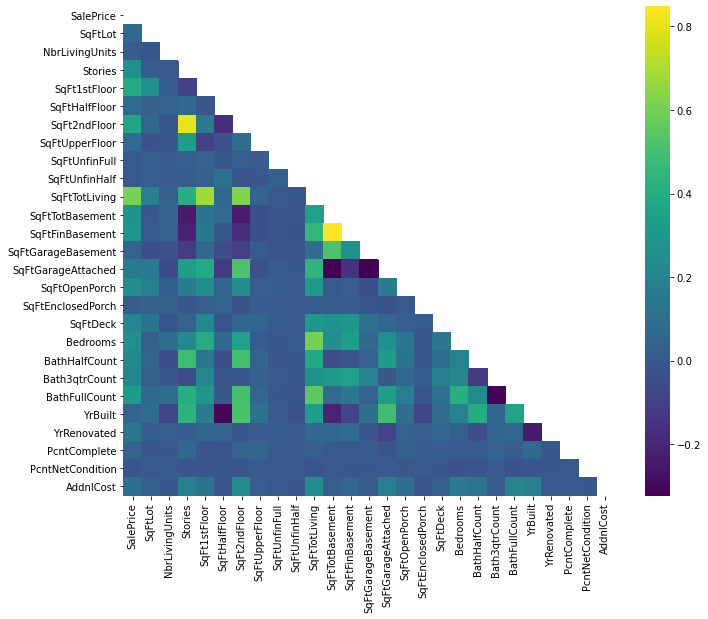

In [123]:
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap='viridis');

### `SqFtTotLiving` Looks Most Correlated
Confirming and printing a sorted list of correlation magnitudes

In [124]:
# creating a sorted list of correlations
np.abs(corr.SalePrice).sort_values(ascending=False).iloc[1:]

SqFtTotLiving         0.609454
SqFt1stFloor          0.392227
SqFt2ndFloor          0.370389
BathFullCount         0.318210
SqFtFinBasement       0.292734
SqFtTotBasement       0.277310
Stories               0.260426
Bedrooms              0.253457
SqFtOpenPorch         0.249485
BathHalfCount         0.225802
SqFtDeck              0.214524
Bath3qtrCount         0.209274
SqFtGarageAttached    0.156516
YrRenovated           0.136423
AddnlCost             0.097212
SqFtHalfFloor         0.080449
SqFtUpperFloor        0.076565
SqFtLot               0.074803
YrBuilt               0.051285
SqFtGarageBasement    0.049425
PcntComplete          0.039122
NbrLivingUnits        0.009062
PcntNetCondition      0.008201
SqFtEnclosedPorch     0.008199
SqFtUnfinFull         0.002262
SqFtUnfinHalf         0.000483
Name: SalePrice, dtype: float64

### Pair Plot For The Top Four Predictors

In [159]:
# collecting the top five predictors and forming data frame
li = ['SalePrice', 'SqFtTotLiving', 'SqFt1stFloor', 'SqFt2ndFloor',\
      'BathFullCount']

four_most_correlated = df[li]

In [160]:
four_most_correlated.head()

,SalePrice,SqFtTotLiving,SqFt1stFloor,SqFt2ndFloor,BathFullCount
5,560000.0,1930,1930,0,2
6,435000.0,1975,1057,918,1
94,1255000.0,2680,1760,0,1
105,380000.0,1750,920,0,1
144,930000.0,2580,1780,0,2


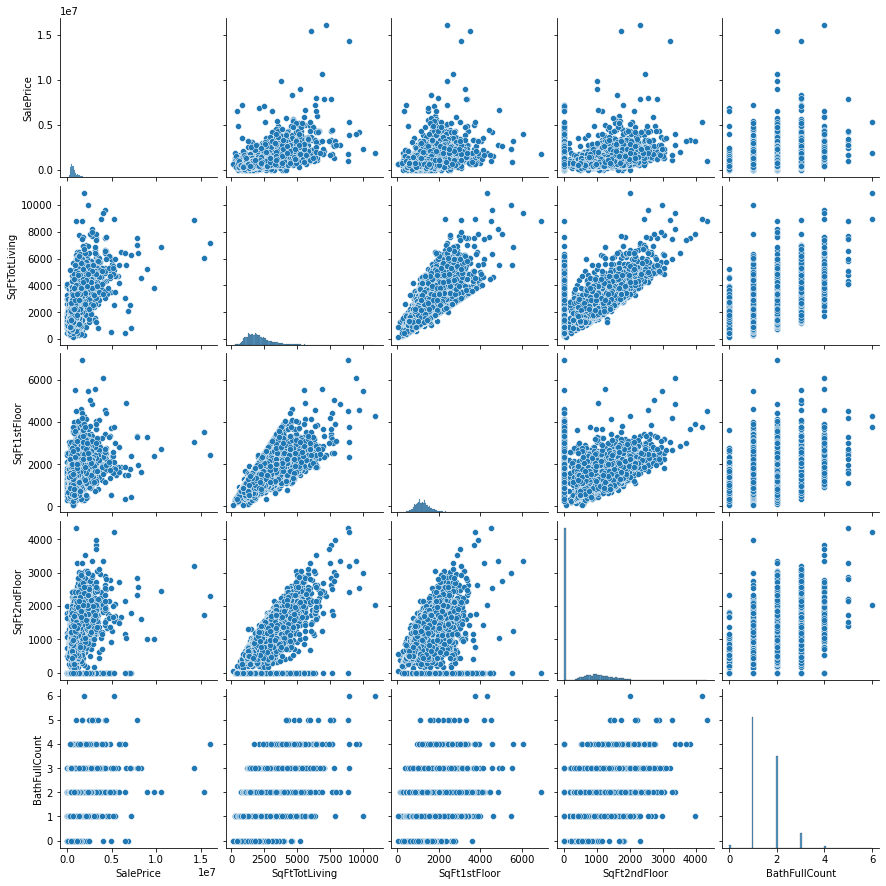

In [161]:
# printing the pairplot
sns.pairplot(four_most_correlated);

# First Simple Model
Creating a baseline model using `SqFtTotLiving` as the predictor. Will be using alpha = .05 for all statistical tests performed throughout the modeling process.

In [128]:
fsm_df = df[['SalePrice', 'SqFtTotLiving']].copy()

In [129]:
fsm = ols(formula="SalePrice ~ SqFtTotLiving", data=fsm_df)
fsm_results = fsm.fit()

In [130]:
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     9644.
Date:                Fri, 26 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:40:28   Log-Likelihood:            -2.3609e+05
No. Observations:               16323   AIC:                         4.722e+05
Df Residuals:                   16321   BIC:                         4.722e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.239e+04   8798.112     -1.408      0.159   -2.96e+04    4857.279
SqFtTotLiving   378.4219      3.853     98.206      0.000     370.869     385.975
==============================================================================
Omnibus:                    21907.178   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13486307.854
Skew:                           7.274   Prob(JB):                         0.00
Kurtosis:                     143.063   Cond. No.                     5.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [131]:
rainbow_statistic, rainbow_p_value = linear_rainbow(fsm_results)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 0.859061271344214
Rainbow p-value: 0.999999999996513


#### Results

Since the p-value was greater than .05, we fail to reject the null hypothesis and conclude that the model is linearly predicted by the feauture. 

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Results
The Jarque-Bera test p-value of 0.00 indicates that the residuals are not normally distributed and that the model violates an assumption of linear regression.

### Homoscadasticity Check: Breusch-Pagan Test
Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the preditors.

### Visual Inspection of the Residuals

In [132]:
y = fsm_df['SalePrice']
y_hat = fsm_results.predict()

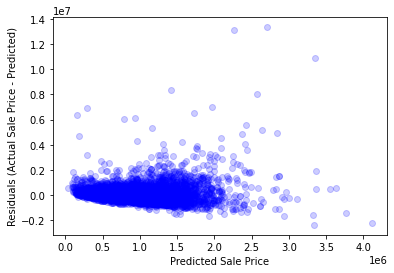

In [133]:
fig2, ax2 = plt.subplots()
ax2.set(xlabel='Predicted Sale Price',
        ylabel='Residuals (Actual Sale Price - Predicted)')
ax2.scatter(x=y_hat, y=y-y_hat, color="blue", alpha=0.2);

In [134]:
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, fsm_df[['SalePrice']])
print('Lagrange Multiplier p-value:', lm_p_value)
print('F-statistic p-value:', f_p_value)

Lagrange Multiplier p-value: nan
F-statistic p-value: 0.0


#### Results
The p-value of 0 indicates that we must reject the null hypothesis and conclude that the variance of the taget is not homogeneous across values of the predictor.

### Independence Check:  Variance Inflation Factor

Skipping this for now, the model only has one predictor, so it is by independent by definition.

### Inspecting the Target and Predictor More Closely
Checking the basic stats, histograms, scatterplot for the target and predictor.

In [135]:
df['SalePrice'].describe()

count    1.632300e+04
mean     7.750344e+05
std      5.836287e+05
min      1.000000e+01
25%      4.570000e+05
50%      6.458650e+05
75%      8.850000e+05
max      1.605000e+07
Name: SalePrice, dtype: float64

In [136]:
df['SqFtTotLiving'].describe()

count    16323.000000
mean      2080.805428
std        939.941911
min        116.000000
25%       1420.000000
50%       1920.000000
75%       2530.000000
max      10910.000000
Name: SqFtTotLiving, dtype: float64

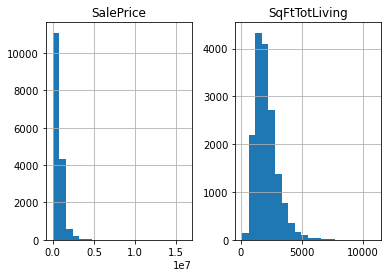

In [137]:
fsm_df.hist(bins=20);

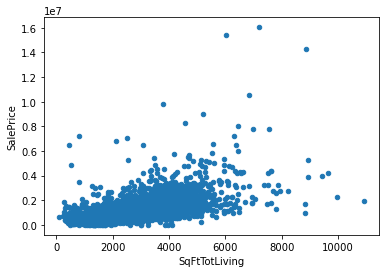

In [138]:
fsm_df.plot.scatter(x='SqFtTotLiving', y='SalePrice');

## Isolating Target and Initial Predictors

### HeatSystem Dataframe

Isolating ```'SalePrice'``` target and ```'HeatSystem'``` predictor in Checking first the few rows, shape, nulls, and unique values.

In [139]:
# Isolating SalePrice target and HeatSystem predictor into a data frame. 
heat_df = df[['SalePrice','HeatSystem']].copy()
heat_df.head(3)

,SalePrice,HeatSystem
5,560000.0,5
6,435000.0,5
94,1255000.0,5


In [140]:
# checking shape
heat_df.shape

(16323, 2)

In [141]:
# checking NaNs
heat_df.isna().sum()

SalePrice     0
HeatSystem    0
dtype: int64

#### Prepping for Model Data Frame

Creating a dictionary of the lookup code descriptions, and using it to make a list of values for use in a new column.  Will use this column in a one-hot-encoding procedure for more descriptive column names in the model dataframe.

In [142]:
# checking unique values
print(heat_df.HeatSystem.unique())
len(heat_df.HeatSystem.unique())

['5' '4' '1' '7' '3' '6' '2' '8' '0']


9

#### Grabbing Lookup Codes

In [143]:
# looking up HeatSystem codes 
lu_df = fn.lookup(look, 108)
lu_df

,LUType,LUItem,LUDescription
243,108,1,Floor-Wall
244,108,2,Gravity
245,108,3,Radiant
246,108,4,Elec BB
247,108,5,Forced Air
248,108,6,Hot Water
249,108,7,Heat Pump
250,108,8,Other


#### Making & Mapping Dictionary of Lookup Codes & Descriptions
Zipping lists of keys and values for dictionary from lookup data frame columns. Creating dictionary and mapping it to the `heat_df` data frame.

In [144]:
# creating heatnames dictionary
heatnames = dict(zip(lu_df.LUItem,lu_df.LUDescription))

In [145]:
heat_df.HeatSystem.map(heatnames)

5         Forced Air
6         Forced Air
94        Forced Air
105          Elec BB
144       Forced Air
             ...    
251274       Elec BB
251275    Forced Air
251276    Forced Air
251278     Heat Pump
251279           NaN
Name: HeatSystem, Length: 16323, dtype: object

#### Making `HeatNames` Column & Dropping `HeatSystems` From Data Frame

In [146]:
heat_df['HeatNames'] = heat_df.HeatSystem.map(heatnames)

In [147]:
fn.dropper(heat_df, 'HeatSystem', True)

#### Checking for `NaN` values and replacing with `'NA'` strings.
Checking for `NaN` types. Since `NaN` values mean there was no lookup code available, replacing `NaN` values with `'NA'` strings.

In [148]:
# checking for NaNs
heat_df['HeatNames'].isna().sum()

19

In [149]:
# filling NaNs with strings
heat_df.fillna('NA', inplace=True)

In [150]:
# checking work
heat_df.isna().sum()

SalePrice    0
HeatNames    0
dtype: int64

#### One-Hot Encoding the HeatSystem Predictor

Instantiating the encoder, fitting the encoder to `heat_df[['HeatNames']]` , and transforming the data. Creating a new `heat_ohe` data frame, dropping the `'HeatNames'` column from ` heat_df2`, and concatenating it will `heat_ohe` to form a new `model_df` data frame.

In [151]:
# instantiating, fitting and transforming
ohcoder = OneHotEncoder(drop='first')

ohcoder.fit(heat_df[['HeatNames']])

transformed = ohcoder.transform(heat_df[['HeatNames']])

In [152]:
# creating heat_ohe data frame and checking the first few columns
heat_ohe = pd.DataFrame(transformed.todense(),\
                       columns = ohcoder.get_feature_names())
heat_ohe.head(3)

,x0_Floor-Wall,x0_Forced Air,x0_Gravity,x0_Heat Pump,x0_Hot Water,x0_NA,x0_Other,x0_Radiant
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
# dropping the 'HeatNames' column from heat_df
heat_dropped = heat_df.drop('HeatNames', axis=1)

#### Creating `model_df` Data Frame

In [154]:
# creating the model dataframe and checking first few rows
model_df = pd.concat([heat_dropped, heat_ohe], axis=1)
model_df.head(3)

,SalePrice,x0_Floor-Wall,x0_Forced Air,x0_Gravity,x0_Heat Pump,x0_Hot Water,x0_NA,x0_Other,x0_Radiant
0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### `model_df` Correlation Matrix and Heatmap

In [155]:
np.abs(model_df.corr().SalePrice).sort_values(ascending=False).iloc[1:]

x0_Heat Pump     0.086496
x0_Floor-Wall    0.029971
x0_Forced Air    0.014015
x0_NA            0.013631
x0_Hot Water     0.010824
x0_Gravity       0.003214
x0_Radiant       0.001641
x0_Other              NaN
Name: SalePrice, dtype: float64

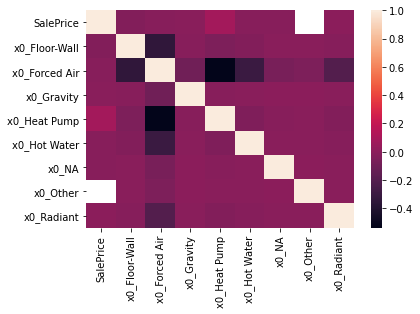

In [156]:
sns.heatmap(model_df.corr());

# plt.savefig('plot.png', dpi=300, bbox_inches='tight')

#### EnclosedPoarch Dataframe

In [157]:
# isolating SalePrice target and SqFtEnclosedPorch predictor
porch_df = df[['SqFtEnclosedPorch']]
porch_df.head()

,SqFtEnclosedPorch
5,0
6,0
94,330
105,0
144,0
